# 1 - Setup

## 1.1 - Imports & Configs

In [1]:
from utils import *
from matplotlib.ticker import FuncFormatter

## 1.2 - Constants & Globals

In [2]:
OUTPUT_CSV = "./output/csv/"
OUTPUT_GRAPH = "./output/graph/"
DF_CLEAN = pd.read_csv("./output/csv/data_clean.csv")
sns.set_theme(style="whitegrid")
plt.rcParams["patch.edgecolor"] = "none"
plt.rcParams["patch.linewidth"] = 0
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14

# 2 - Visão Geral

## 2.1 - Pergunta 13: Os profissionais da área de dados estão trabalhando em qual modalidade?
O modelo de trabalho mais comum entre os profissionais da área de dados neste dataset é o **100% Remoto**, com **50.5%**.<br>
<br>
*Excluidos entrevistados trabalhando nos cargos: "Outra Opção", "Outras Engenharias (não inclui dev)", "Professor/Pesquisador", "Desenvolvedor/ Engenheiro de Software/ Analista de Sistemas" e "Economista".*

In [3]:
# Excluindo entrevistados que não estão trabalhando ou não responderam a pergunta
df_filtered = DF_CLEAN[~DF_CLEAN["P2_a Qual sua situação atual de trabalho?"].isin([
    "Desempregado, buscando recolocação",
    "Desempregado e não estou buscando recolocação",
    "Prefiro não informar"
])]
# Selecionando as colunas de interesse, agrupando por modelo de trabalho e cargo atual e somando a quantidade de entrevistados em cada grupo
df_by_work_model = df_filtered[["P0 id", "P2_a Qual sua situação atual de trabalho?", "P2_f Cargo Atual", "P2_r Atualmente qual a sua forma de trabalho?"]].groupby(["P2_r Atualmente qual a sua forma de trabalho?", "P2_f Cargo Atual"]).size().reset_index(name="count")


In [4]:
# Removendo entrevistados que não trabalham na área de dados, agrupando pelo modelo de trabalho e somando a quantidade de entrevistados em cada grupo
grouped_data = df_by_work_model[~df_by_work_model["P2_f Cargo Atual"].isin([
    "Outra Opção",
    "Outras Engenharias (não inclui dev)",
    "Professor/Pesquisador",
    "Desenvolvedor/ Engenheiro de Software/ Analista de Sistemas",
    "Economista"
])].groupby("P2_r Atualmente qual a sua forma de trabalho?").sum().reset_index()
grouped_data = grouped_data.drop(columns=["P2_f Cargo Atual"])
grouped_data = grouped_data.replace({"P2_r Atualmente qual a sua forma de trabalho?": {r"Modelo híbrido flexível.*": "Modelo híbrido flexível"}}, regex=True)
grouped_data



,P2_r Atualmente qual a sua forma de trabalho?,count
0,Modelo 100% presencial,447
1,Modelo 100% remoto,1727
2,Modelo híbrido com dias fixos de trabalho pres...,568
3,Modelo híbrido flexível,680


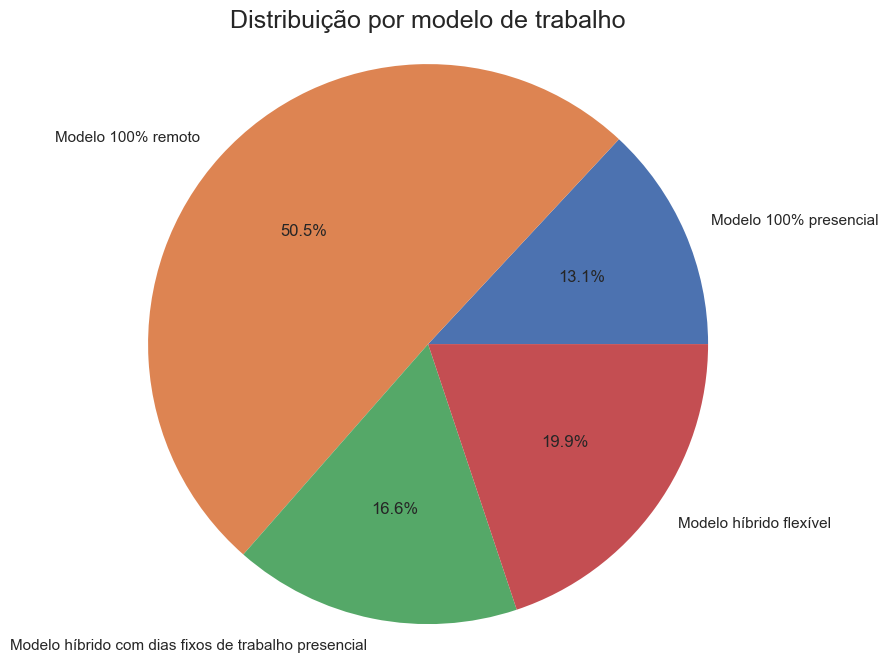

In [5]:
# Plotando o gráfico
plt.figure(figsize=(10, 8))
plt.pie(grouped_data["count"], labels=grouped_data["P2_r Atualmente qual a sua forma de trabalho?"], autopct="%1.1f%%")
plt.title("Distribuição por modelo de trabalho")
plt.axis("equal")
plt.savefig(OUTPUT_GRAPH+"pie_modelo_trabalho.png")
plt.show()

## 2.2 - Pergunta 3: Qual o nível de inglês predominante entre os profissionais mais experientes?
No dataset não há menções ao nível de inglês, porem, é possível inferir que entre os profissionais que trabalham para o mercado externo (e provavelmente possuem fluencia em inglês), o nível de experiencia é proporcionalmente maior, enquanto para o mercado interno é notado o oposto. Vale salientar que a taxa amostral de profissionais que trabalham para empresas estrangeiras é de somente ~1% do total de entrevistados, o que é muito baixo e pode não representar a realidade.

In [6]:
# Seleciona somente os entrevistados que trabalham para empresas estrangeiras
df_abroad = DF_CLEAN[DF_CLEAN["P2_a Qual sua situação atual de trabalho?"].isin(["Vivo fora do Brasil e trabalho para empresa de fora do Brasil", "Vivo no Brasil e trabalho para empresa de fora do Brasil"])]
df_abroad.shape

(64, 279)

In [7]:
df_abroad.shape[0] / DF_CLEAN.shape[0]

0.012091441526544493

In [8]:
# Criando df com a quantidade de pessoas que trabalham fora do brasil
domestic = DF_CLEAN[~DF_CLEAN["P2_a Qual sua situação atual de trabalho?"].isin(["Vivo fora do Brasil e trabalho para empresa de fora do Brasil", "Vivo no Brasil e trabalho para empresa de fora do Brasil"])][["P0 id", "P2_i Quanto tempo de experiência na área de dados você tem?"]].groupby(["P2_i Quanto tempo de experiência na área de dados você tem?"]).size().reset_index(name="count")
# Criando df com a quantidade de pessoas que trabalham fora do brasil
abroad = DF_CLEAN[DF_CLEAN["P2_a Qual sua situação atual de trabalho?"].isin(["Vivo fora do Brasil e trabalho para empresa de fora do Brasil", "Vivo no Brasil e trabalho para empresa de fora do Brasil"])][["P0 id", "P2_i Quanto tempo de experiência na área de dados você tem?"]].groupby(["P2_i Quanto tempo de experiência na área de dados você tem?"]).size().reset_index(name="count")
# Calculando a soma total de cada grupo
total_domestic = domestic["count"].sum()
total_abroad = abroad["count"].sum()
# Calculando a proporção de cada faixa de nível de experiência dentro de cada grupo
domestic["Proportion"] = domestic["count"] / total_domestic
abroad["Proportion"] = abroad["count"] / total_abroad
# Une os dois DataFrames na coluna "P2_i Quanto tempo de experiência na área de dados você tem?"
merged_df = pd.merge(domestic, abroad, on="P2_i Quanto tempo de experiência na área de dados você tem?", suffixes=("_domestic", "_abroad"))
# Renomeia as colunas para melhor legibilidade
merged_df.columns = ["Experience", "Count_Domestic", "Proportion_Domestic", "Count_Abroad", "Proportion_Abroad"]
# Seta o index para a coluna "Experience" para facilitar a plotagem
order = ["Mais de 10 anos", "de 7 a 10 anos", "de 5 a 6 anos", "de 4 a 6 anos", "de 3 a 4 anos", "de 1 a 2 anos", "Menos de 1 ano", "Não tenho experiência na área de dados"]
merged_df.set_index("Experience", inplace=True)
# Definir a ordem das categorias
merged_df = merged_df.reindex(order)

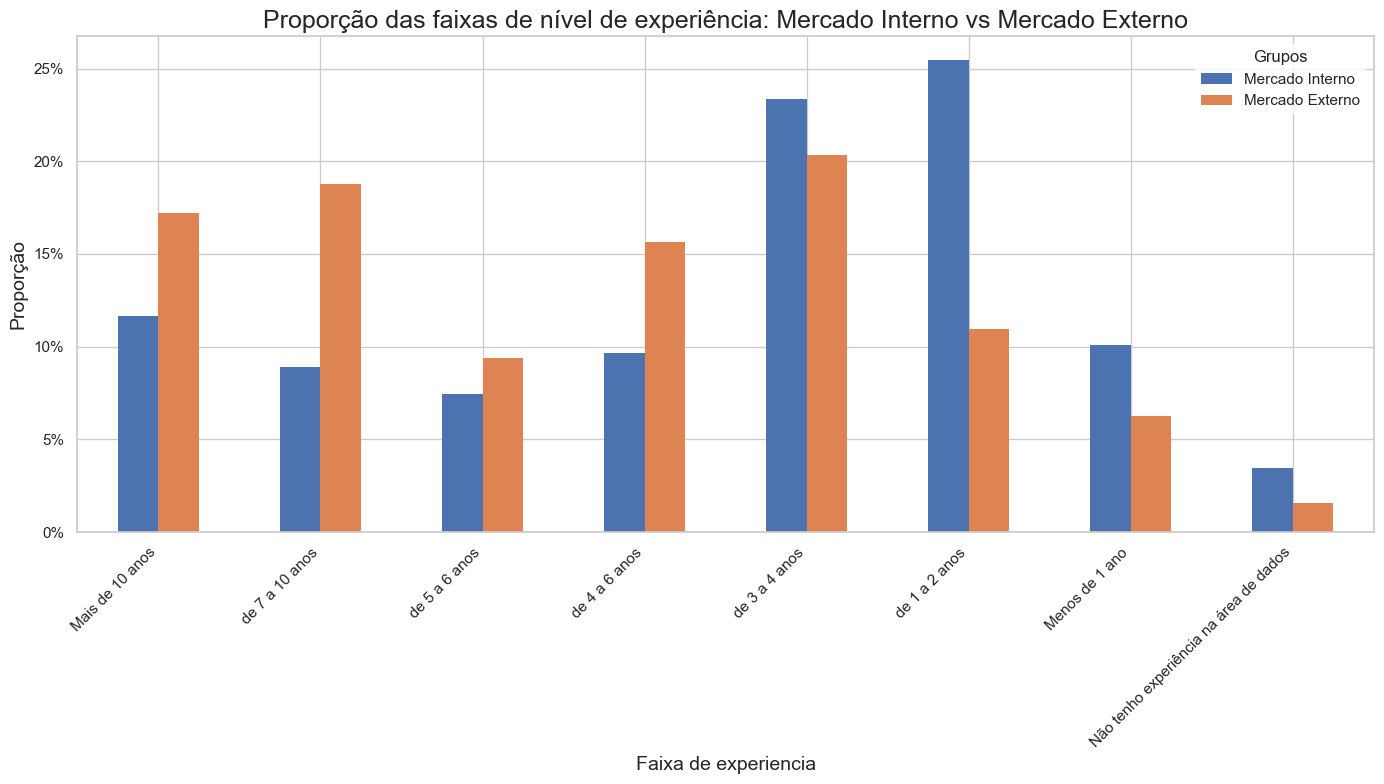

In [9]:
# Plota a proporção de cada faixa de nível de experiência para ambos os grupos
merged_df[["Proportion_Domestic", "Proportion_Abroad"]].plot(kind="bar", figsize=(14, 8))
plt.title("Proporção das faixas de nível de experiência: Mercado Interno vs Mercado Externo")
plt.xlabel("Faixa de experiencia")
plt.ylabel("Proporção")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Grupos", labels=["Mercado Interno", "Mercado Externo"])
plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent))
plt.tight_layout()
plt.savefig(OUTPUT_GRAPH+"experiencia_mercado_interno_vs_externo.png")
plt.show()

## 2.3 Pergunta 1: Quais estados concentram os profissionais com mais conhecimento em Python e SQL?

In [10]:
# Separa as colunas que referenciam linguagens de programação
cols_prog_langs = [col for col in DF_CLEAN.columns if 'python' in col.lower() or 'sql' in col.lower() or "linguagens" in col.lower()]
df_prog_langs = DF_CLEAN[["P0 id"] + cols_prog_langs[:4]]
df_prog_langs = pd.get_dummies(df_prog_langs, columns=cols_prog_langs[:4], drop_first=True)
for col in df_prog_langs.columns:
    if col.startswith(tuple(cols_prog_langs[:4])):
        df_prog_langs[col] = df_prog_langs[col].astype(float)
cols_prog_langs = [col for col in df_prog_langs.columns if 'python' in col.lower() or 'sql' in col.lower()]
df_prog_langs = df_prog_langs[["P0 id"] + cols_prog_langs]
# Calcula o conhecimento de cada linguagem de programação para um número entre 0 e 1 para cada profissional
weights = [0.3, 0.4, 0.3]
df_prog_langs["Nivel_SQL"] = (df_prog_langs["P4_d_1 SQL_1.0"] * weights[0] + df_prog_langs["P4_e Entre as linguagens listadas abaixo, qual é a que você mais utiliza no trabalho?_SQL"] * weights[1] + df_prog_langs["P4_f Entre as linguagens listadas abaixo, qual é a sua preferida?_SQL"] * weights[2])
df_prog_langs["Nivel_Python"] = (df_prog_langs["P4_d_3 Python_1.0"] * weights[0] + df_prog_langs["P4_e Entre as linguagens listadas abaixo, qual é a que você mais utiliza no trabalho?_Python"] * weights[1] + df_prog_langs["P4_f Entre as linguagens listadas abaixo, qual é a sua preferida?_Python"] * weights[2])
# Define se um profissional domina uma linguagem de programação ou não, com base em um limiar
df_prog_langs["Domina_SQL"] = (df_prog_langs["Nivel_SQL"] > 0.5).astype(int)
df_prog_langs["Domina_Python"] = (df_prog_langs["Nivel_Python"] > 0.5).astype(int)
# Adiciona o valor da UF onde reside para cada profissional
df_prog_langs["UF"] = DF_CLEAN["P1_i_1 uf onde mora"]
# Remove colunas que não serão mais usadas
df_prog_langs.drop(columns=["P4_d_1 SQL_1.0", "P4_d_3 Python_1.0", "P4_e Entre as linguagens listadas abaixo, qual é a que você mais utiliza no trabalho?_Python", "P4_e Entre as linguagens listadas abaixo, qual é a que você mais utiliza no trabalho?_SQL",	"P4_f Entre as linguagens listadas abaixo, qual é a sua preferida?_Python", "P4_f Entre as linguagens listadas abaixo, qual é a sua preferida?_SQL"], inplace=True)
df_prog_langs

,P0 id,Nivel_SQL,Nivel_Python,Domina_SQL,Domina_Python,UF
0,001b2d1qtli8t9z7oqgdhj001b2d4i0g,0.3,1.0,0,1,MG
1,0026aa3fwd78u0026asg7456tfkjg2cs,0.7,0.6,1,1,ES
2,00r21rb9pusd1b0v7ew00r21rw3dy69w,0.7,0.6,1,1,SP
3,00urm3jf2cek12w6ygue00urm3jzd17j,0.0,0.0,0,0,SP
4,00v0az4g792svil00vn6y1kfm9hq8vy9,0.3,1.0,0,1,MG
...,...,...,...,...,...,...
5288,zyg9519671iqrgy93qzyg95183k8ix5f,0.0,0.0,0,0,MG
5289,zyppgxzxko25qkgwsbrgpzyppgxzxs81,0.3,1.0,0,1,RN
5290,zysl5f50cnz3r0cbe6t2zysrxbzfsrng,0.3,1.0,0,1,SP
5291,zyt2656c9e1becxp457zyt26566dsng8,0.0,0.0,0,0,SP


In [11]:
# Soma a quantidade de profissionais que dominam cada linguagem em cada UF
dominancia_count = df_prog_langs.groupby("UF").agg({"Domina_SQL": "sum", "Domina_Python": "sum",})
dominancia_count["Total"] = dominancia_count["Domina_SQL"] + dominancia_count["Domina_Python"]
dominancia_count = dominancia_count.sort_values(ascending=False, by="Total").reset_index()
# Soma os valores de dominancia para cada UF
dominancia_sum = df_prog_langs.groupby("UF").agg({"Nivel_SQL": "sum", "Nivel_Python": "sum",})
dominancia_sum["Total"] = dominancia_sum["Nivel_SQL"] + dominancia_sum["Nivel_Python"]
dominancia_sum = dominancia_sum.sort_values(ascending=False, by="Total").reset_index()

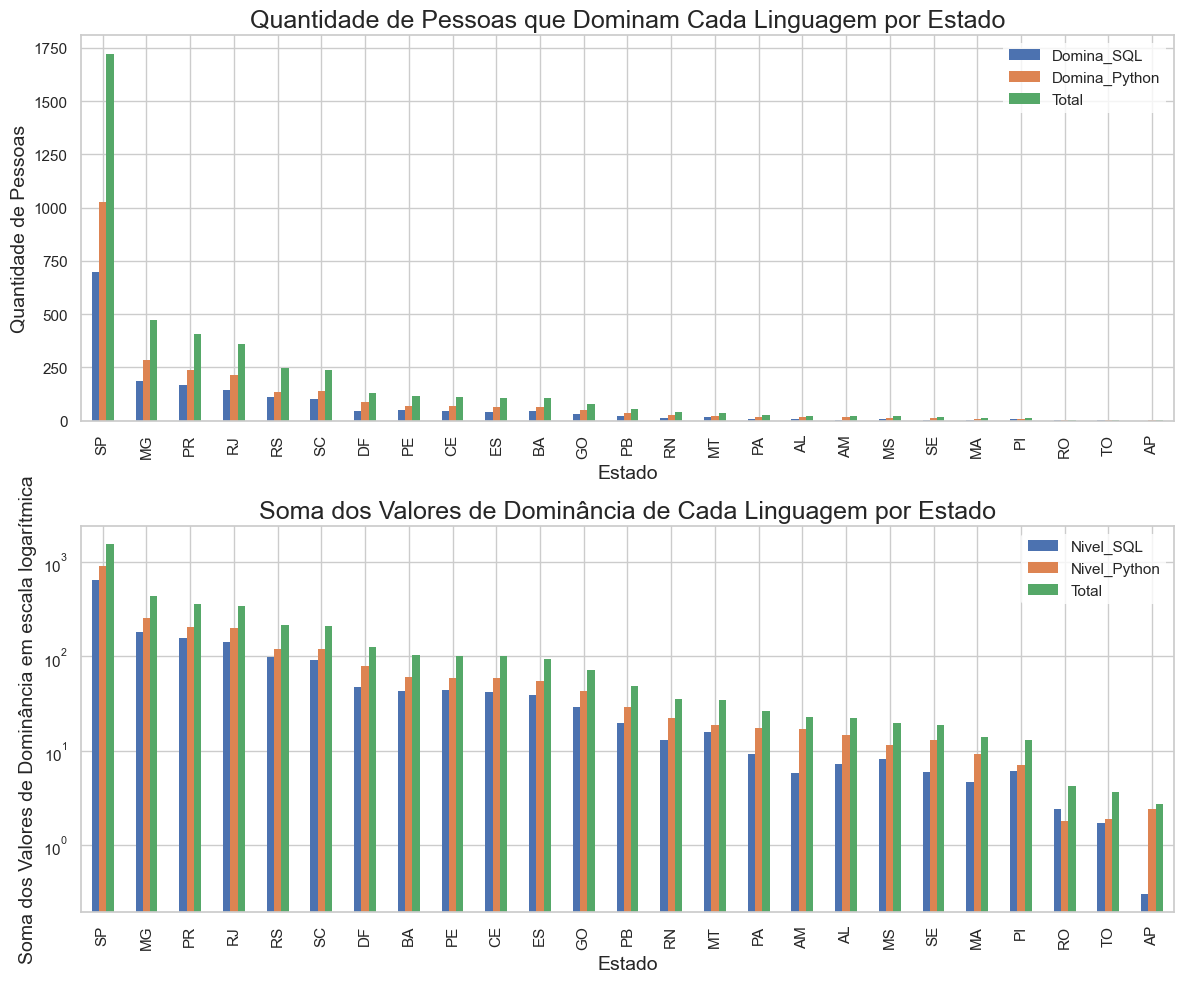

In [12]:
# Plotar gráficos
# Gráfico de barras para a quantidade de pessoas que dominam cada linguagem
fig, ax = plt.subplots(2, 1, figsize=(12, 10))
dominancia_count.plot(kind='bar', x='UF', ax=ax[0])
ax[0].set_title('Quantidade de Pessoas que Dominam Cada Linguagem por Estado')
ax[0].set_ylabel('Quantidade de Pessoas')
ax[0].set_xlabel('Estado')
# Gráfico de barras para a soma dos valores de dominância de cada linguagem
dominancia_sum.plot(kind='bar', x='UF', ax=ax[1])
ax[1].set_title('Soma dos Valores de Dominância de Cada Linguagem por Estado')
ax[1].set_ylabel('Soma dos Valores de Dominância em escala logarítmica')
ax[1].set_xlabel('Estado')
ax[1].set_yscale("log")
plt.tight_layout()
plt.savefig(OUTPUT_GRAPH+"bar_dominancia_linguagens_por_UF.png")
plt.show()

# 3 - Visão DA

In [13]:
# Criar df apenas de analistas de dados
df_targets = DF_CLEAN[DF_CLEAN["P2_f Cargo Atual"] == "Analista de Dados/Data Analyst"]
# Dropar colunas com 100% de valores nulos
df_targets = df_targets.dropna(axis=1, how='all')

In [14]:
# Criar df de analistas de dados + outros cargos que podem ocupar a mesma vaga
df_targets_ext = DF_CLEAN[DF_CLEAN["P2_f Cargo Atual"].isin(["Analista de Dados/Data Analyst", "Analista de BI/BI Analyst", "Cientista de Dados/Data Scientist"])]
# Dropar colunas com 100% de valores nulos
df_targets = df_targets.dropna(axis=1, how='all')
df_targets_ext.shape

(2100, 279)

## 3.1 - Pergunta 8: Qual o nível de escolaridade dos profissionais que atuam como Cientista de Dados Sênior?
-	Mestrado: **36.4%** (99)
-	Graduação/Bacharelado:  **24.6%** (67)
-	Pós-graduação:  **19.9%** (54)
-	Doutorado ou Phd:  **18.0%** (49)
-	Estudante de Graduação/Não tenho graduação formal:  **1.1%** (3)

In [15]:
# Separa somente os DS Sêniores e agrupa por nível de ensino
grouped_data = df_targets_ext[
    (df_targets_ext["P2_f Cargo Atual"] == "Cientista de Dados/Data Scientist") &
    (df_targets_ext["P2_g Nivel"] == "Sênior")
][["P0 id", "P1_l Nivel de Ensino"]]
# Agrupa e conta os valores
grouped_data = grouped_data.groupby("P1_l Nivel de Ensino").size().reset_index(name="count")
# Identifica grupos muito pequenos
small_group = grouped_data[grouped_data["count"] < 3]["P1_l Nivel de Ensino"].tolist()
# Concatena o nome dos grupos muito pequenos em um só, separando com /
small_group_concat = "/".join(small_group)
# Substitui os grupos muito pequenos pelo nome concatenado
grouped_data["P1_l Nivel de Ensino"] = grouped_data["P1_l Nivel de Ensino"].apply(lambda x: small_group_concat if x in small_group else x)
# Agrupa novamente e soma os valores
grouped_data = grouped_data.groupby("P1_l Nivel de Ensino").sum().sort_values(by="count").reset_index()

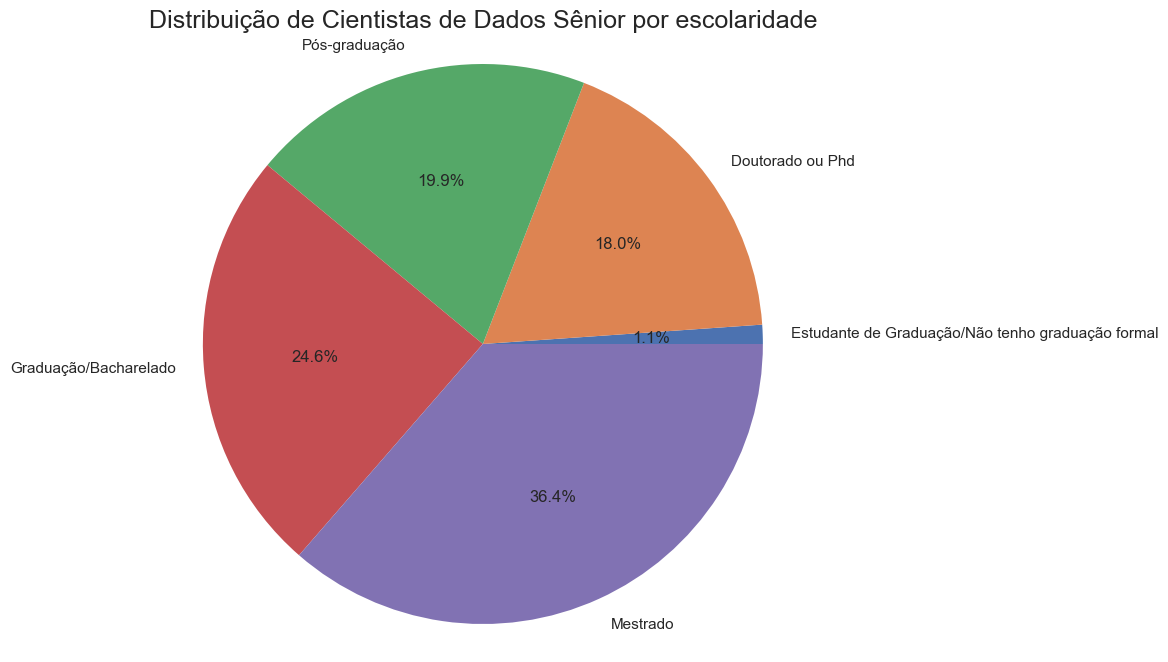

In [16]:
# Plota o gráfico
plt.figure(figsize=(10, 8))
fig = plt.pie(grouped_data["count"], labels=grouped_data["P1_l Nivel de Ensino"], autopct="%1.1f%%")
plt.title("Distribuição de Cientistas de Dados Sênior por escolaridade")
plt.axis("equal")
plt.savefig(OUTPUT_GRAPH+"pie_DS_senior_escolaridade.png")
plt.show()

## 3.2 - Pergunta 12: Qual a faixa salarial por senioridade de analistas e cientistas de dados?

In [17]:
# Remove cargo de BI Analyst pois não é o foco da pergunta, seleciona as colunas de interesse e agrupa por cargo, nível e faixa salarial. O método size() conta o número de ocorrências de cada combinação de cargo, nível e faixa salarial e o método unstack() reorganiza os dados para que as faixas salariais se tornem colunas
grouped_data = df_targets_ext[~df_targets_ext["P2_f Cargo Atual"].isin(["Analista de BI/BI Analyst"])][["P0 id", "P2_f Cargo Atual", "P2_g Nivel", "P2_h Faixa salarial"]].groupby(["P2_f Cargo Atual", "P2_g Nivel", "P2_h Faixa salarial"]).size().unstack(fill_value=0)


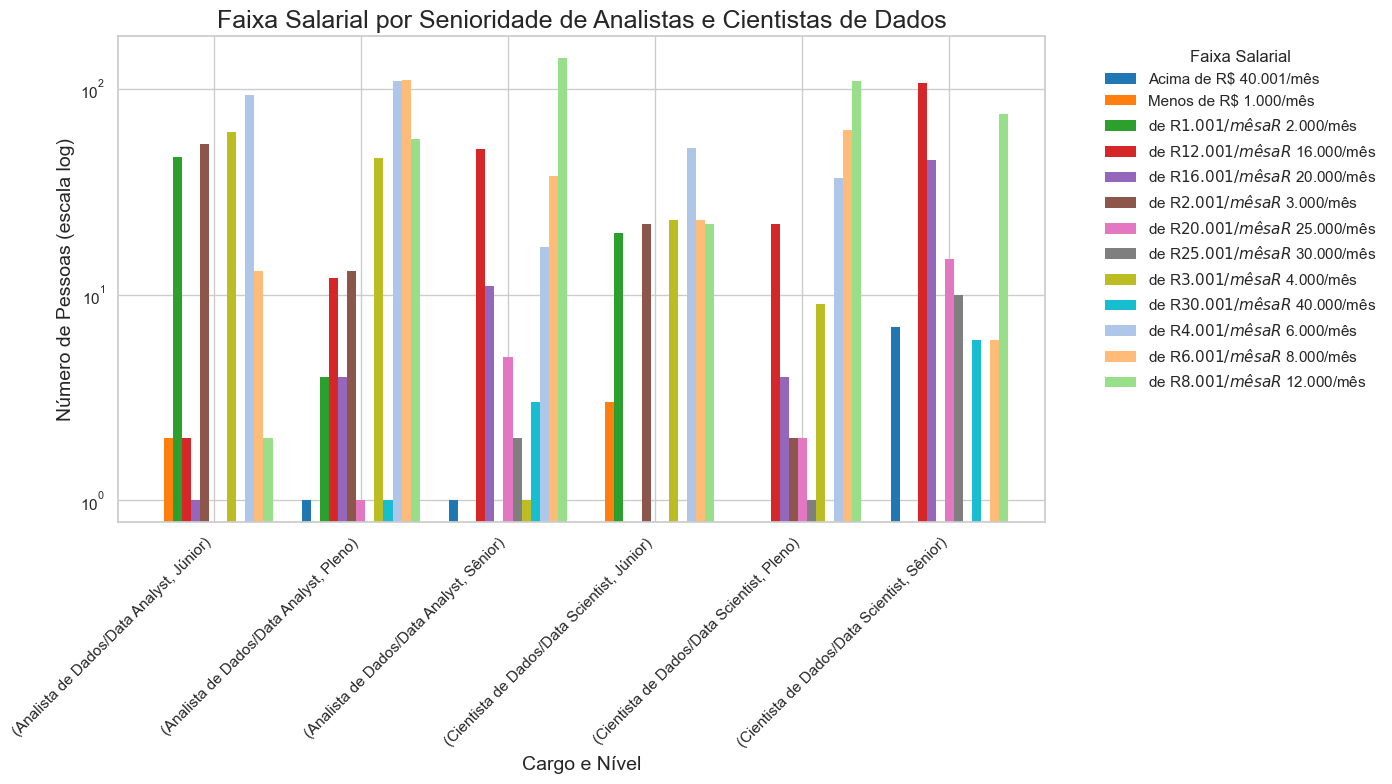

In [18]:
# Plotar o gráfico de barras empilhadas
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf", "#aec7e8", "#ffbb78", "#98df8a"]
fig = grouped_data.plot(kind="bar", figsize=(14, 8), color=colors, width=0.8)
plt.title("Faixa Salarial por Senioridade de Analistas e Cientistas de Dados")
plt.xlabel("Cargo e Nível")
plt.ylabel("Número de Pessoas (escala log)")
# Transforma a escala do eixo y em logaritmo para melhor visualização (diminui a diferença de tamanho entre as barras muito pequenas e as muito grandes)
fig.set_yscale("log")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Faixa Salarial", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.savefig(OUTPUT_GRAPH+"bar_faixa_salario.png")
plt.show()

## 4.2 - Visão gestores

In [19]:
# Criar dataset apenas de gestores
df_heads = DF_CLEAN[DF_CLEAN["P2_d Gestor?"] == 1.0]
df_heads = df_heads.dropna(axis=1, how='all')
df_heads.shape

(896, 70)

# 5 - Exportar DataFrames

In [20]:
# Exportar dataframes para .csv
df_targets.to_csv(OUTPUT_CSV+"data_dataAnalysts.csv", index=False)
df_targets_ext.to_csv(OUTPUT_CSV+"data_dataAnalysts_ext.csv", index=False)
df_abroad.to_csv(OUTPUT_CSV+"data_abroad.csv", index=False)
df_heads.to_csv(OUTPUT_CSV+"data_gestores.csv", index=False)
df_prog_langs.to_csv(OUTPUT_CSV+"data_prog_linguagens.csv", index=False)